# Problem Statement

Music streaming platforms need to recommend relevant songs to users from millions of tracks.
This project implements and compares three recommendation approaches:

1. Baseline: Popularity-based recommendations (recommend top songs to everyone)
2. ALS (Alternating Least Squares): Advanced collaborative filtering
3. Factorization Machines: Machine learning with user features

In this project, we use the Last.fm 360K dataset, scaled to 10,000 users and 5,000 artists for computational efficiency.

Dataset: http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html (depreated)

Download link: https://zenodo.org/record/6090214/files/lastfm-dataset-360K.tar.gz

## Data Loading

In [5]:
!curl -L -o lastfm-dataset-360K.tar.gz https://zenodo.org/records/6090214/files/lastfm-dataset-360K.tar.gz

# Extract
!tar -xzf lastfm-dataset-360K.tar.gz

# Remove tar file
!rm lastfm-dataset-360K.tar.gz

data_path = 'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  542M  100  542M    0     0  17.9M      0  0:00:30  0:00:30 --:--:-- 19.4M


In [7]:
import pandas as pd

# Load
df = pd.read_csv(data_path, sep='\t', header=None,
                 names=['user_id', 'artist_id', 'artist_name', 'play_count'])

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique artists: {df['artist_id'].nunique():,}")
print(f"Play count range: {df['play_count'].min()} - {df['play_count'].max()}")

df.head()

Total interactions: 17,535,655
Unique users: 358,868
Unique artists: 160,112
Play count range: 0 - 419157


,user_id,artist_id,artist_name,play_count
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706


## Visualize and Scale the Data

Visualizations of user play counts, artist popularity, and user activity distributions.

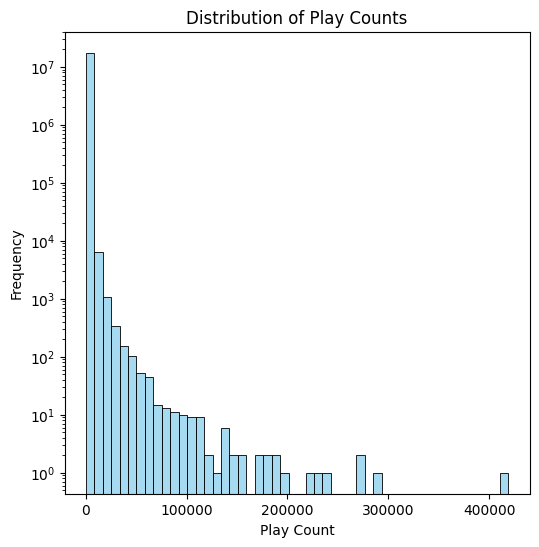

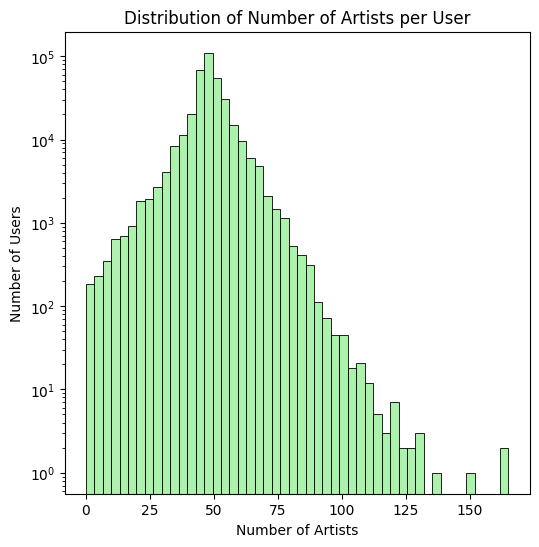

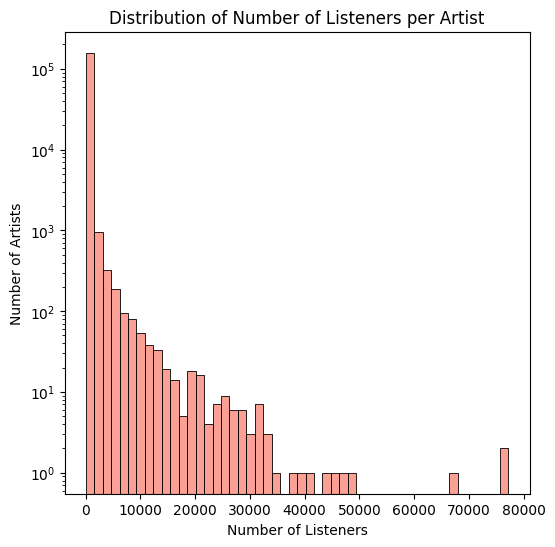

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize play count distribution
plt.figure(figsize=(6, 6))
sns.histplot(df['play_count'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Play Counts')
plt.xlabel('Play Count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

# Visualize user activity distribution
plt.figure(figsize=(6, 6))
sns.histplot(user_activity['num_artists'], bins=50, kde=False, color='lightgreen')
plt.title('Distribution of Number of Artists per User')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Users')
plt.yscale('log')
plt.show()

# Visualize artist popularity distribution
plt.figure(figsize=(6, 6))
sns.histplot(artist_popularity['num_listeners'], bins=50, kde=False, color='salmon')
plt.title('Distribution of Number of Listeners per Artist')
plt.xlabel('Number of Listeners')
plt.ylabel('Number of Artists')
plt.yscale('log')
plt.show()

## Filter and Scale

In [10]:
# Filter users with at least 20 unique artists
user_counts = df.groupby('user_id').size()
active_users = user_counts[user_counts >= 20].index
df_filtered = df[df['user_id'].isin(active_users)]

# Filter artists with at least 10 unique listeners
artist_counts = df_filtered.groupby('artist_id').size()
popular_artists = artist_counts[artist_counts >= 10].index
df_filtered = df_filtered[df_filtered['artist_id'].isin(popular_artists)]

# Scale down to the top 10,000 users and 5,000 artists
top_users = df_filtered['user_id'].value_counts().head(10000).index
top_artists = df_filtered['artist_id'].value_counts().head(5000).index
df_scaled = df_filtered[
    (df_filtered['user_id'].isin(top_users)) &
    (df_filtered['artist_id'].isin(top_artists))
]

print(f"Final scaled data: {len(df_scaled):,} interactions")
print(f"Users: {df_scaled['user_id'].nunique():,}")
print(f"Artists: {df_scaled['artist_id'].nunique():,}")

Final scaled data: 503,817 interactions
Users: 9,999
Artists: 5,000


## Preprocessing

In [11]:
from scipy.sparse import csr_matrix

# Create user and artist mappings
user_mapping = {user: idx for idx, user in enumerate(df_scaled['user_id'].unique())}
artist_mapping = {artist: idx for idx, artist in enumerate(df_scaled['artist_id'].unique())}

# Map IDs to indices
df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)

# Create sparse matrix
rows = df_scaled['user_idx'].values
cols = df_scaled['artist_idx'].values
data = df_scaled['play_count'].values
sparse_matrix = csr_matrix((data, (rows, cols)),
                           shape=(len(user_mapping), len(artist_mapping)))

print(f"Sparse matrix shape: {sparse_matrix.shape}")
print(f"Non-zero entries: {sparse_matrix.nnz:,}")

Sparse matrix shape: (9999, 5000)
Non-zero entries: 503,796


/tmp/ipython-input-4266519952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['user_idx'] = df_scaled['user_id'].map(user_mapping)
/tmp/ipython-input-4266519952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['artist_idx'] = df_scaled['artist_id'].map(artist_mapping)


## Train/Test Split

In [12]:
import numpy as np

# Split into train and test sets
train_matrix = sparse_matrix.copy()
test_interactions = []

test_ratio = 0.2
min_interactions = 5

for user_idx in range(sparse_matrix.shape[0]):
    user_interactions = sparse_matrix.getrow(user_idx)
    nonzero_items = user_interactions.nonzero()[1]

    if len(nonzero_items) >= min_interactions:
        n_test = max(1, int(len(nonzero_items) * test_ratio))
        test_items = np.random.choice(nonzero_items, n_test, replace=False)

        for item_idx in test_items:
            test_interactions.append({
                'user_idx': user_idx,
                'item_idx': item_idx,
                'rating': sparse_matrix[user_idx, item_idx]
            })
            train_matrix[user_idx, item_idx] = 0

train_matrix.eliminate_zeros()

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Test interactions: {len(test_interactions):,}")

Train matrix shape: (9999, 5000)
Test interactions: 96,786


In [13]:
# Check for data leakage
assert train_matrix.nnz + len(test_interactions) == sparse_matrix.nnz, "Data leakage detected"

# Check sparsity
train_sparsity = (1 - train_matrix.nnz / (train_matrix.shape[0] * train_matrix.shape[1])) * 100
print(f"Train set sparsity: {train_sparsity:.2f}%")

# Check for cold-start users
train_user_counts = np.array(train_matrix.sum(axis=1)).flatten()
cold_start_users = np.sum(train_user_counts == 0)
print(f"Cold-start users: {cold_start_users}")

Train set sparsity: 99.19%
Cold-start users: 0


In [14]:
# Log transformation
matrix_log = sparse_matrix.copy().astype(float)
matrix_log.data = np.log1p(matrix_log.data)

# Binary transformation
matrix_binary = sparse_matrix.copy()
matrix_binary.data = (matrix_binary.data > 0).astype(float)

# User-normalized transformation
matrix_normalized = sparse_matrix.copy().astype(float)
row_sums = np.array(matrix_normalized.sum(axis=1)).flatten()
row_sums[row_sums == 0] = 1  # Avoid division by zero
for i in range(matrix_normalized.shape[0]):
    matrix_normalized.data[matrix_normalized.indptr[i]:matrix_normalized.indptr[i+1]] /= row_sums[i]